In [123]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt

In [124]:
df = pd.read_csv('data/kospi.csv')

df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-30,2183.489990,2206.199951,2177.879883,2206.199951,2206.199951,480400
1,2019-01-31,2222.879883,2222.879883,2201.219971,2204.850098,2204.850098,545200
2,2019-02-01,2211.929932,2218.780029,2201.409912,2203.459961,2203.459961,479400
3,2019-02-07,2215.770020,2215.790039,2196.770020,2203.419922,2203.419922,427800
4,2019-02-08,2192.010010,2192.479980,2171.959961,2177.050049,2177.050049,391000


In [125]:
scaler = MinMaxScaler()
df[['Open', 'High', 'Low', 'Close', 'Volume']] = scaler.fit_transform(df[['Open', 'High', 'Low', 'Close', 'Volume']])

df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-30,0.722898,0.732351,0.745525,0.759235,2206.199951,0.242113
1,2019-01-31,0.763058,0.750069,0.769089,0.757866,2204.850098,0.274771
2,2019-02-01,0.751894,0.745714,0.769280,0.756456,2203.459961,0.241609
3,2019-02-07,0.755809,0.742538,0.764596,0.756415,2203.419922,0.215603
4,2019-02-08,0.731584,0.717777,0.739548,0.729669,2177.050049,0.197057


In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431 entries, 0 to 430
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       431 non-null    object 
 1   Open       431 non-null    float64
 2   High       431 non-null    float64
 3   Low        431 non-null    float64
 4   Close      431 non-null    float64
 5   Adj Close  431 non-null    float64
 6   Volume     431 non-null    float64
dtypes: float64(6), object(1)
memory usage: 23.7+ KB


In [127]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000
mean,0.660665,0.656462,0.673942,0.673018,2121.195427,0.326694
std,0.162642,0.165504,0.163478,0.161306,159.038127,0.130715
min,0.000000,0.000000,0.000000,0.000000,1457.640015,0.000000
25%,0.594537,0.583024,0.607581,0.606183,2055.299927,0.222079
50%,0.670789,0.663381,0.686152,0.683206,2131.239990,0.306774
75%,0.751404,0.747642,0.764424,0.762323,2209.244995,0.408704
max,1.000000,1.000000,1.000000,1.000000,2443.580078,1.000000


In [128]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

device

device(type='cuda')

In [129]:
X = df[['Open', 'High', 'Low', 'Volume']].values
y = df[['Close']].values

In [130]:
X.shape, y.shape

((431, 4), (431, 1))

In [131]:
def seq_data(x, y, sequence_length):    
    x_seq = []
    y_seq = []
    for i in range(len(x) - sequence_length):
        x_seq.append(x[i:i+sequence_length])
        y_seq.append(y[i+sequence_length])

    return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device)

In [132]:
split = 200
sequence_length = 5

x_seq, y_seq = seq_data(X, y, sequence_length)
x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]
x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]

x_train_seq.shape, y_train_seq.shape ,x_test_seq.shape, y_test_seq.shape

(torch.Size([200, 5, 4]),
 torch.Size([200, 1]),
 torch.Size([226, 5, 4]),
 torch.Size([226, 1]))

In [133]:
trainset = TensorDataset(x_train_seq, y_train_seq)
testset = TensorDataset(x_test_seq, y_test_seq)

batch_size = 20
train_loader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=testset, batch_size=batch_size, shuffle=False)

In [134]:
x_seq.size()

torch.Size([426, 5, 4])

In [135]:
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8

In [136]:
class VanillaRNN(nn.Module):
    def __init__(self, input_size, hidden_size, sequence_length, num_layers, device) -> None:
        super().__init__()
        self.device = device
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size*sequence_length, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
        out, _ = self.rnn(x, h0)
        out = out.reshape(out.shape[0], -1) # many to many
        out = self.fc(out)

        return out

In [137]:
model = VanillaRNN(
    input_size=input_size,
    hidden_size=hidden_size,
    sequence_length=sequence_length,
    num_layers=num_layers,
    device=device
).to(device)

In [138]:
criterion = nn.MSELoss()
lr = 1e-3
num_epochs = 500
optimizer = optim.Adam(model.parameters(), lr=lr)

In [139]:
model.train()
loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs):
    running_loss = 0.0

    for data in train_loader:
        seq, target = data
        out = model(seq)
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        running_loss += loss.item()

    loss_graph.append(running_loss/n)

    if epoch % 100 == 0:
        print(f'[epoch: {epoch}] loss: {running_loss/n:.4f}')

[epoch: 0] loss: 0.0309
[epoch: 100] loss: 0.0009
[epoch: 200] loss: 0.0006
[epoch: 300] loss: 0.0005
[epoch: 400] loss: 0.0004


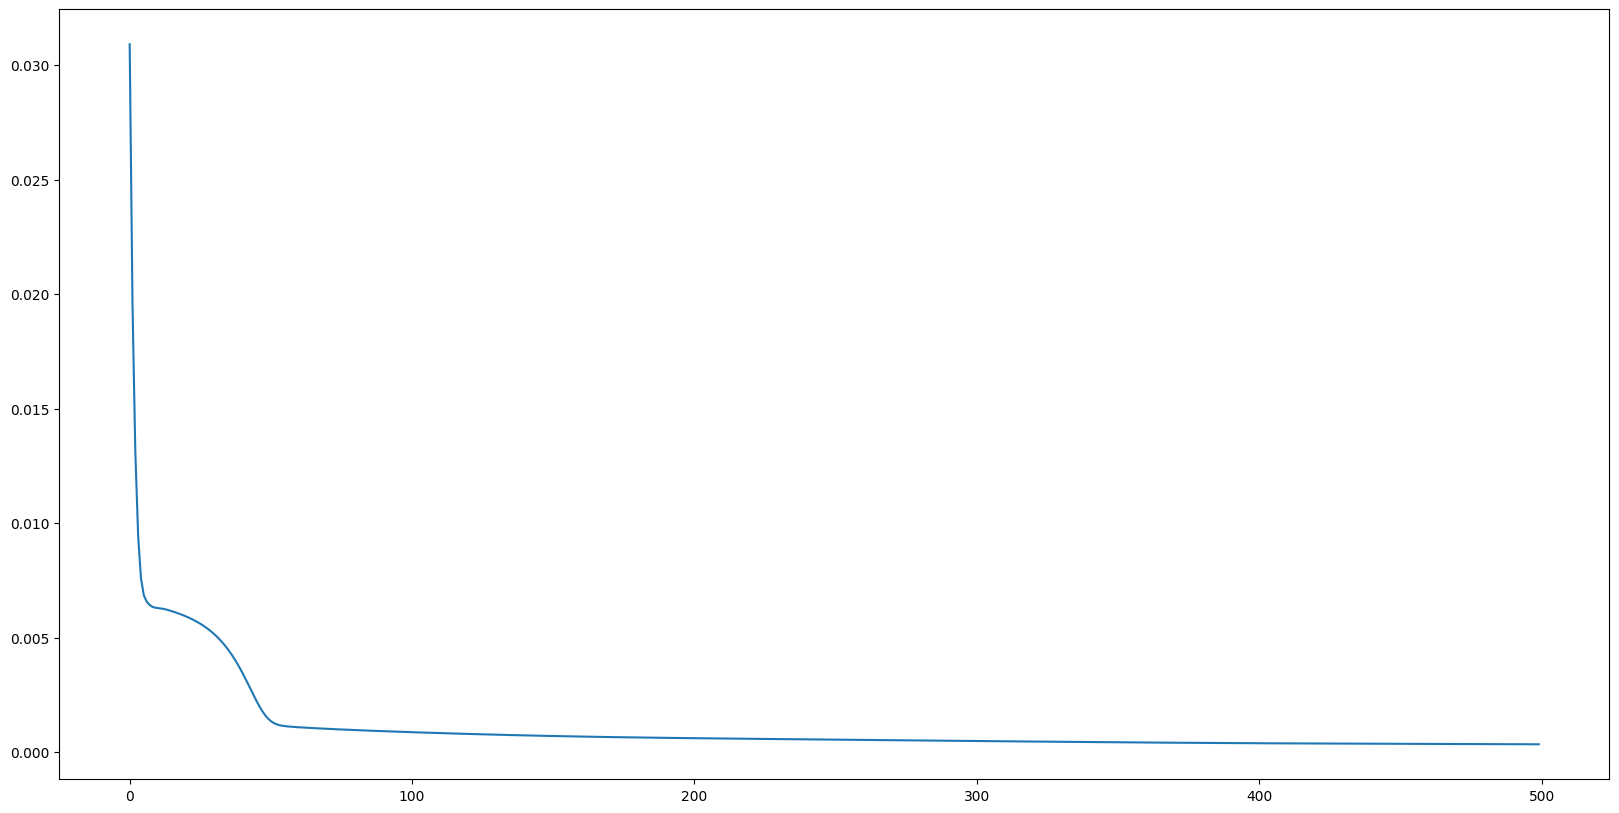

In [140]:
plt.figure(figsize=(20, 10))
plt.plot(loss_graph)
plt.show()

In [141]:
np.linspace(0, 1, 100)

array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
       0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
       0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
       0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
       0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
       0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
       0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
       0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
       0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
       0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
       0.70707071, 0.71717172, 0.72727273, 0.73737374, 0.74747

In [142]:
def plotting(train_loader, test_loader, actual):
    with torch.inference_mode():
        train_pred = []
        test_pred = []
        for data in train_loader:
            seq, _ = data
            out = model(seq)
            train_pred += out.cpu().numpy().tolist()

        for data in test_loader:
            seq, _ = data
            out = model(seq)
            test_pred += out.cpu().numpy().tolist()
    
    total = train_pred+test_pred

    plt.figure(figsize=(20, 10))
    plt.plot(np.ones(100)*len(train_pred), np.linspace(0, 1, 100))
    plt.plot(actual, '--')
    plt.plot(total, 'b', linewidth=0.6)

    plt.legend(['train boundary', 'actual', 'prediction'])

    plt.show()
        

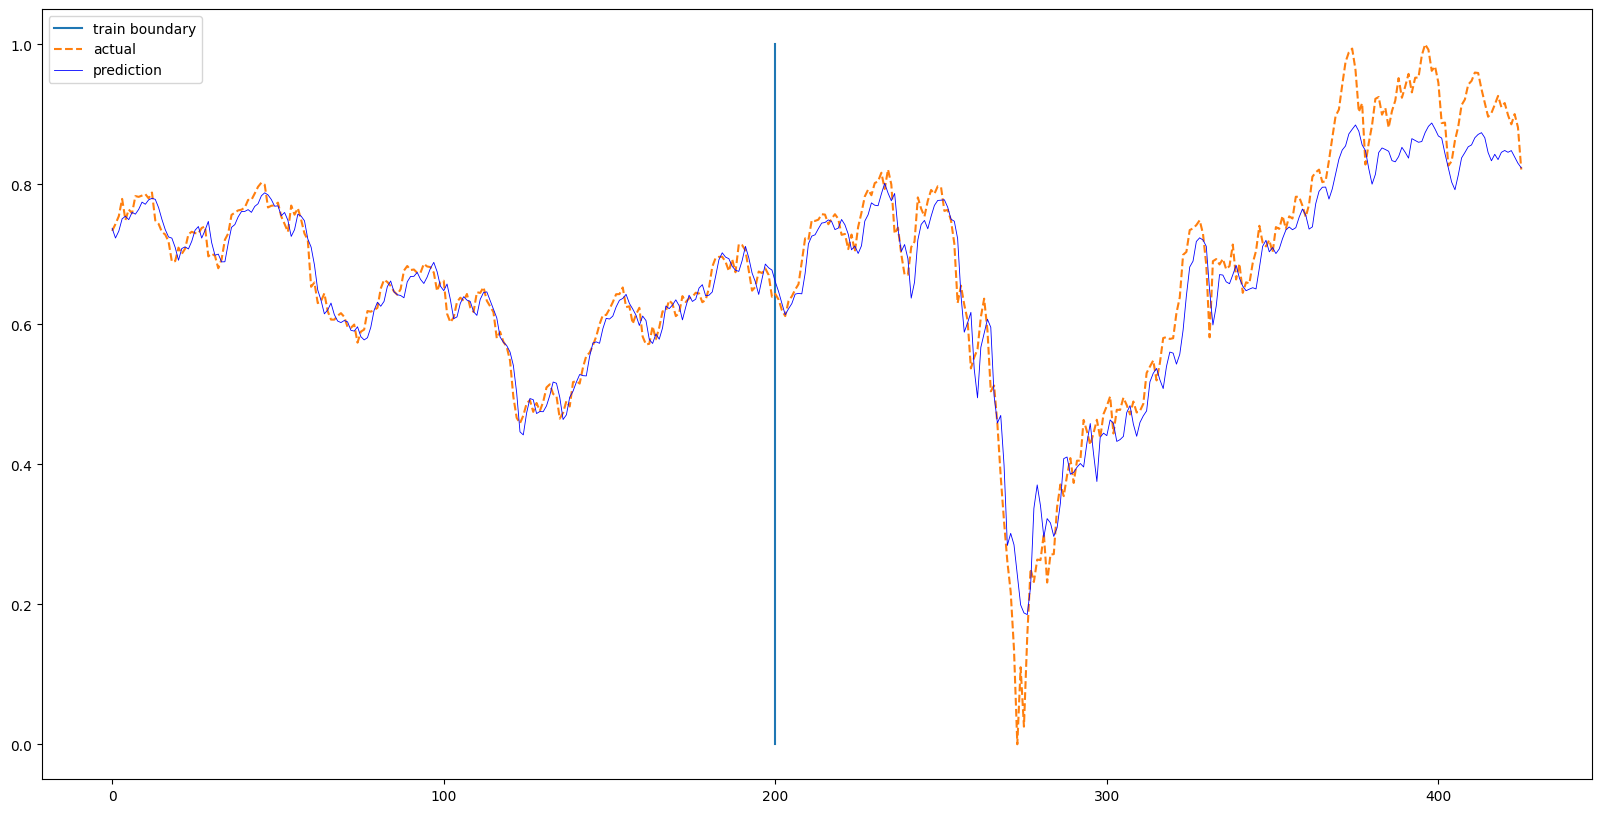

In [143]:
plotting(train_loader, test_loader, df['Close'][sequence_length:].values)